In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNEL_SIZE = 3
EPOCHS = 20

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
L = len(dataset)
L

68

In [7]:
type(dataset)

tensorflow.python.data.ops.batch_op._BatchDataset

In [8]:
for im, lb in dataset.take(1):
    print(im.shape)
    print(lb.numpy())

(32, 256, 256, 3)
[1 1 0 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 0 1 0]


(32, 256, 256, 3) -> 32 batch size, 256,256 image size ,3 channel(RGB)

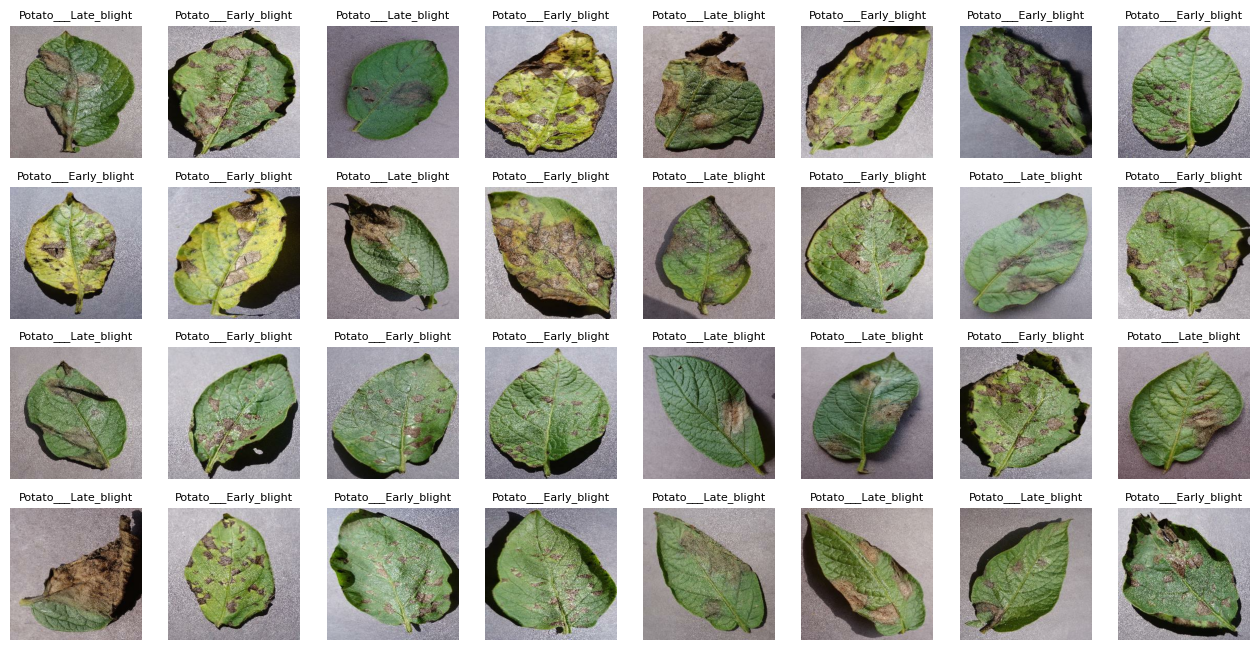

In [9]:
plt.figure(figsize=(16,8))
for im, lb in dataset.take(1):
    for i in range(32):
        ax = plt.subplot(4,8,i+1)
        plt.imshow(im[i].numpy().astype("uint8"))
        plt.title(class_name[lb[i]], fontsize=8)
        plt.axis("off")


100 dataset,
80 -> training
20 -> 10-validation, 10-testing

In [10]:
L

68

In [11]:
def data_split_function(dataset, train_size=0.8, test_size=0.1, val_size=0.1, shuffle=True, shuffle_size=3000):
    ds_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=3)
    train_size = int(train_size*ds_size)
    val_size = int(val_size*ds_size)
    
    train_ds = dataset.take(train_size)

    val_ds = dataset.skip(train_size).take(val_size)

    test_ds = dataset.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [12]:
train_data, val_data, test_data = data_split_function(dataset)

In [13]:
len(train_data), len(val_data), len(test_data)

(54, 6, 8)

# preprocessing dataset

In [14]:
shfl=1000
train_data = train_data.cache().shuffle(shfl).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(shfl).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(shfl).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
data_augementation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.25),
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical")
])

In [17]:
image_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL_SIZE)
n_classes = 3 #early,late,healthy

In [18]:
model = models.Sequential([
    resize_rescale,
    data_augementation,
    
    # LAYER-1
    layers.Conv2D(32, (3,3), activation="relu", input_shape=image_shape),
    layers.MaxPooling2D((2,2)),
    
    # LAYER-2
    layers.Conv2D(32, activation="relu", kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
    
    # LAYER-3
    layers.Conv2D(32, activation="relu", kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
   
    # LAYER-4
    layers.Conv2D(32, activation="relu", kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
   
    # LAYER-5
    layers.Conv2D(32, activation="relu", kernel_size=(3,3)),
    layers.MaxPooling2D((2,2)),
   
    # flatten and dense
    layers.Flatten(),
    layers.Dense(32, activation="relu"),
    layers.Dense(n_classes, activation="softmax")
    
])

In [19]:
model.build(input_shape=image_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                 

In [21]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    train_data,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_data
)

Epoch 1/10
12/54 [=====>........................] - ETA: 3:32 - loss: 0.9124 - accuracy: 0.4740

## plotting the history of model

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show() 

In [ ]:
plt.plot(history.history['accuracy'], label='Training Loss')
plt.plot(history.history['val_accuracy'], label='Validation Loss')
plt.legend()
plt.show() 